In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# je télécharge les données météo à partir de pandas, j'ai prétraité le .csv pour pouvoir télécharger les données facilement!
# si j'avais à rabouter plusieurs .csv j'aurais peut-être gossé pandas pour travailler le .csv de façon programmatique mais pour un fichier je m'en tabarnakais
df = pd.read_csv(r"C:\Users\alexi\Desktop\2scool4cool\passive seismic\Mont Saint Pierre\Données météo\RST_20250721.csv")#, delimiter=';')

# en spécifiant que l'index du dataframe est la colonne TIMESTAMP, on peut facilement faire des sélections temporelles
df.index = pd.to_datetime(df['TIMESTAMP'])

# je m'intéresse uniquement à la période du 15 au 23 juin 2025, là où on a des données sismiques
df = df[df.index > '2025-06-15']
df = df[df.index < '2025-06-23']
df

,TIMESTAMP,RECORD,BATTERY,EXT1,Therm1,EXT2,Therm2,140cm,75cm,30cm,0cm1,0cm2
TIMESTAMP,,,,,,,,,,,,
2025-06-15 00:15:00,2025-06-15 00:15,226,3.63,-88.632805,12.41,-130.419403,11.65,8.23,10.28,12.26,12.23,12.36
2025-06-15 00:30:00,2025-06-15 00:30,227,3.63,-88.630745,12.24,-130.415878,11.40,8.23,10.29,12.24,12.03,12.20
2025-06-15 00:45:00,2025-06-15 00:45,228,3.63,-88.628677,12.02,-130.407959,11.26,8.23,10.29,12.21,11.87,12.06
2025-06-15 01:00:00,2025-06-15 01:00,229,3.63,-88.630058,11.95,-130.419846,11.05,8.23,10.29,12.18,11.76,11.94
2025-06-15 01:15:00,2025-06-15 01:15,230,3.63,-88.631889,11.90,-130.419403,11.15,8.23,10.30,12.15,11.74,11.87
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-22 22:45:00,2025-06-22 22:45,988,3.63,-88.293625,15.88,-129.640762,15.72,9.53,11.67,14.16,15.77,15.94
2025-06-22 23:00:00,2025-06-22 23:00,989,3.63,-88.286751,16.01,-129.639008,15.72,9.53,11.68,14.17,15.86,15.85
2025-06-22 23:15:00,2025-06-22 23:15,990,3.63,-88.288589,16.42,-129.641205,16.07,9.53,11.68,14.17,16.05,15.90


In [3]:
# j'utilise obspy et un "client" pour télécharger les données sismiques d'un géophone qui m'intéresse
# tu pourrais modifier le code un peu pour pouvoir télécharger les données de plusieurs géophones en même temps, 
# mais il faudrait quelques modifications dans les cellules plus bas

import obspy
from obspy.clients.filesystem import sds

# tu vas bien sûr devoir changer le chemin d'accès
client = sds.Client("C:\\Users\\alexi\\Desktop\\2scool4cool\\passive seismic\\Mont Saint Pierre\\archive")

# la commande get_all_nslc() te permet de lister tous les channels disponibles dans le SDS
channels = client.get_all_nslc()

# je filtre les canaux pour ne garder que ceux d'un géophone, ici République Du Congo
channels = [c for c in channels if 'RDC48' in c]

stream = obspy.Stream()
for chn in channels:

    # la commande get_waveforms peut télécharger les données sismiques pour un canal pour une range de date, 
    # mais ça peut devenir couteux pas mal lorsque tu as trop de données! 
    # c'est viable pour une semaine mais on devrait modifier le code pour plusieurs semaines voir des mois
    st = client.get_waveforms(*chn, starttime=obspy.core.UTCDateTime('2025-06-15'), endtime=obspy.UTCDateTime('2025-07-01'))

    # ici je gosse un peu pour filtrer les données
    st.taper(max_percentage=0.05, type='cosine', max_length=10.0)
    st.filter('bandpass', freqmin=1, freqmax=40, corners=2, zerophase=True)
    st.detrend('linear')
    st.detrend('demean')

    # tu peux essayer de décimer les données mais ça limite les fréquences à 25 Hz, c'est un peu contraignant
    #st.decimate(2, no_filter=True)

    # on fusionne les traces et remplit par des zéros
    st.merge(fill_value=0)
    stream += st

In [4]:
# l'objet stream contient les trois canaux du géophone spécifié
stream

3 Trace(s) in Stream:
AM.RDC48.00.EHE | 2025-06-14T23:59:59.999999Z - 2025-06-22T12:39:46.509999Z | 100.0 Hz, 65038652 samples
AM.RDC48.00.EHN | 2025-06-14T23:59:59.999999Z - 2025-06-22T12:39:45.439999Z | 100.0 Hz, 65038545 samples
AM.RDC48.00.EHZ | 2025-06-14T23:59:59.999999Z - 2025-06-22T12:39:46.509999Z | 100.0 Hz, 65038652 samples

In [5]:
from scipy.signal import spectrogram
from scipy.ndimage import median_filter
import xarray as xr
from matplotlib.dates import num2date

# ici j'utilise xarray pour manipuler les données de façon plus efficace
def z2da(f, t, z, fbins):
    # z2da (ou z to data array) convertit les données du spectrogramme en un DataArray xarray
    z = xr.DataArray(z, dims=['frequency', 'time'], coords={'frequency': f, 'time': t})
    z = z.groupby_bins('frequency', bins=fbins, labels=(fbins[1:] + fbins[:-1]) / 2).median()
    z = z.rename({'frequency_bins': 'freqs'})
    return z

def compute_spectrograms(data, fs, nperseg, noverlap, fbins):
    # je calcule un spectrogramme pour les données sismiques
    f, t, Z = spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # ensuite je transforme l'output de scipy.spectrogram en DataArray
    zda = z2da(f, t, Z, fbins=fbins)
    return zda

# quelques paramètres pour le spectrogramme
fs = stream[0].stats.sampling_rate
fbins = np.arange(0, fs // 2, 0.01)
nperseg = int(fs * 60 * 60)
noverlap = int(nperseg / 2)

# je fais une boucle pour pouvoir calculer le spectrogramme pour chaque canal
Zs = []
for st in stream:

    # ici tu peux facilement commenter pour faire du 1bit ou non
    data = st.data
    data = np.sign(data)
    
    # je calcule les spectrogrammes et en fait des DataArrays
    z = compute_spectrograms(data, fs=fs, nperseg=nperseg, noverlap=noverlap, fbins=fbins)

    # il faudrait changer la manière dont on gère les canaux ici pour pouvoir gérer plusieurs géophones en même temps
    z['channel'] = st.stats.channel
    Zs.append(z)

# je m'assure que le temps est bien aligné avec les fonctions de matplotlib
mpltimes = stream[0].times('matplotlib')[0]
Z = xr.concat(Zs, dim='channel')
Z['time'] = num2date(Z.time / 86400 + mpltimes)

In [ ]:
# avec %matplotlib qt, les graphiques peuvent être interactifs
# tu peux utiliser %matplotlib inline pour afficher des graphiques statiques aussi

%matplotlib qt

# création de la figure
fig, axs = plt.subplots(4, 1, sharex='all', figsize=(15, 6))
fig.tight_layout(rect=(0, 0, 0.85, 1))
small_axes = []

# affichage des spectrogrammes pour chaque canal
for i, ax in enumerate(axs[:3]):
    z = Z.isel(channel=i)
    z = z.where((10 < z.freqs) & (z.freqs < 15), drop=True)
    z = z.rolling(freqs=11, center=True).median()
    z = z / z.max('freqs')
    vmin, vmax = z.quantile([0.00, 0.99])
    ax.pcolormesh(z.time, z.freqs, z, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
    ax.text(0.99, 0.99, z.channel.values, transform=ax.transAxes, ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # ici je rajoute un petit axis à côté pour afficher la moyenne des spectres
    bbox = ax.get_position()
    small_ax = fig.add_axes([bbox.x1 + 0.01, bbox.y0, 0.1, bbox.height])
    small_ax.plot(z.mean('time'), z.freqs, c='tab:blue', lw=1)
    small_ax.plot(z.median('time'), z.freqs, c='tab:orange', lw=1)
    
    # je m'assure que les axes soient partagés
    ax.sharey(axs[0])
    small_ax.sharey(ax)
    small_axes.append(small_ax)
    small_ax.sharex(small_axes[0])
    small_ax.yaxis.tick_right()

axs[0].set_xlim(axs[0].get_xlim())

# maintenant j'affiche aussi les données météo
axs[-1].plot(df.index, df['EXT2'], c='tab:blue', lw=1)
ax2 = axs[-1].twinx()
ax2.plot(df.index, df['0cm2'], c='tab:orange', lw=1)

In [ ]:
from scipy.ndimage import median_filter

# ici j'affiche les spectres moyens de chaque canal
# tu peux utiliser la commande Z.sel pour choisir un canal spécifique
E = Z.sel(channel='EHE').median('time')
N = Z.sel(channel='EHN').median('time')
V = Z.sel(channel='EHZ').median('time')
plt.plot(E.freqs, E)
plt.plot(N.freqs, N)
plt.plot(V.freqs, V)

# j'essaie également un "filtre médian" pour lisser les spectres et retirer les harmoniques douteuses
plt.plot(V.freqs, median_filter(V.values, size=51), lw=1, label='median filter')
plt.show()

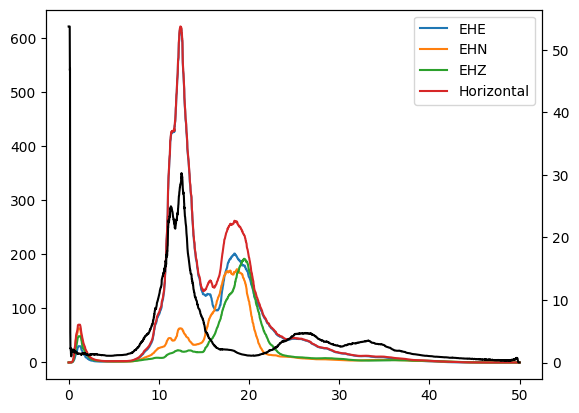

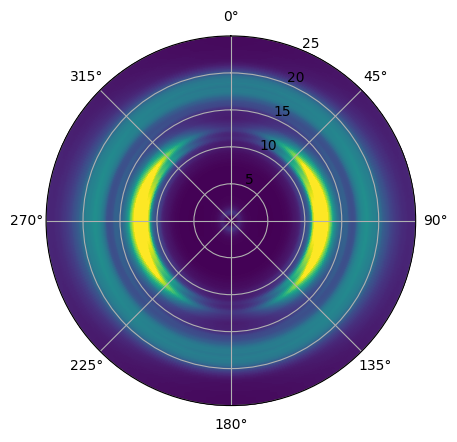

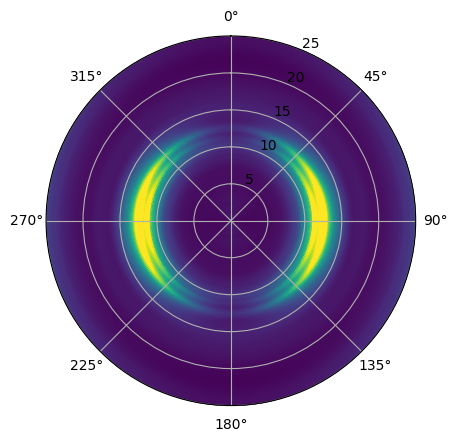

In [ ]:
%matplotlib inline

# je calcule l'azimuths pour les composantes horizontales
azimuths = np.linspace(0, 360, 360)
cos = np.cos(np.deg2rad(azimuths)) ** 2
sin = np.sin(np.deg2rad(azimuths)) ** 2

# j'applique le filtre médian partout pour lisser les spectres, tu peux essayer sans aussi
E = median_filter(Z.sel(channel='EHE').median('time'), size=51)
N = median_filter(Z.sel(channel='EHN').median('time'), size=51)
V = median_filter(Z.sel(channel='EHZ').median('time'), size=51)

# H stands for horizontal
H = np.sqrt(E**2 + N**2)

# je fais une figure où je compare les différents spectres 
fig = plt.figure()
plt.plot(Z.freqs, E, label='EHE')
plt.plot(Z.freqs, N, label='EHN')
plt.plot(Z.freqs, V, label='EHZ')
plt.plot(Z.freqs, H, label='Horizontal')
plt.legend(),
plt.twinx()
plt.plot(Z.freqs, H / (V + 1e-16), c='k')

# je calcule l'énergie des spectres en fonction de l'orientation
# cos et sin sont déjà squared
orientation = sin[None, :] * E[:, None] + cos[None, :] * N[:, None]

# j'utilise np.quantile pour gérer les valeurs extrêmes dans l'affichage des données
vmin, vmax = np.quantile(orientation, [0.01, 0.99])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.pcolormesh(np.deg2rad(azimuths), Z.freqs, orientation, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
ax.set_ylim(0, 25)

# on veut que le Nord soit en haut et que ça tourne dans le sens horaire, pas trigonométrique
ax.set_theta_offset(.5*np.pi) 
ax.set_theta_direction(-1) 

# on peut aussi calculer le ratio Horizontal over Vertical (HVSR) tu checkras ça mais je suis pas sûr de comment l'interpré
HoV = orientation / V[:, None]
vmin, vmax = np.quantile(HoV, [0.01, 0.99])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.pcolormesh(np.deg2rad(azimuths), Z.freqs, HoV, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
ax.set_ylim(0, 25)
ax.set_theta_offset(.5*np.pi) 
ax.set_theta_direction(-1) 

plt.show()


In [ ]:
# ici j'essaie de calculer l'énergie des spectres en fonction de l'orientation 3D
azimuths = np.linspace(0, 180, 180)  # degrees
dips = np.linspace(0, 90, 90)        # degrees

# on convertit en trigo
theta = np.deg2rad(azimuths)         # azimuth
phi = np.deg2rad(dips)               # dip

# on square toute
sin_t2 = np.sin(theta)**2
cos_t2 = np.cos(theta)**2
sin_p2 = np.sin(phi)**2
cos_p2 = np.cos(phi)**2

# on doit agrandir les dimensions pour faire du broadcasting
sin_t2 = sin_t2[None, :, None]            # shape (1, n_az, 1)
cos_t2 = cos_t2[None, :, None]
sin_p2 = sin_p2[:, None, None]           # shape (n_dip, 1, 1)
cos_p2 = cos_p2[:, None, None]

# Power spectra (1D arrays for each freq)
P_E = Z.sel(channel='EHE').median('time').values[None, None, :]  # shape (1, 1, n_freq,)
P_N = Z.sel(channel='EHN').median('time').values[None, None, :]
P_Z = Z.sel(channel='EHZ').median('time').values[None, None, :]

# Compute directional power for all dips, azimuths, and freqs
# Shape: (n_dip, n_azimuth, n_freq)
orientation = (P_E * sin_t2 * cos_p2 +
               P_N * cos_t2 * cos_p2 +
               P_Z * sin_p2)

# orientation est de shape (ndip, nazimuth, nfreq)
orientation = xr.DataArray(orientation, dims=['dip', 'azimuth', 'frequency'],
                           coords={'dip': dips, 'azimuth': azimuths, 'frequency': Z.freqs.values})

orientation

<xarray.DataArray (dip: 90, azimuth: 180, frequency: 4999)> Size: 648MB
array([[[0.0057806 , 0.00585663, 0.00575689, ..., 0.00448044,
         0.00449077, 0.00454076],
        [0.00578028, 0.00585627, 0.00575661, ..., 0.00448047,
         0.0044908 , 0.00454074],
        [0.00577933, 0.00585521, 0.00575577, ..., 0.00448053,
         0.00449089, 0.00454069],
        ...,
        [0.00577933, 0.00585521, 0.00575577, ..., 0.00448053,
         0.00449089, 0.00454069],
        [0.00578028, 0.00585627, 0.00575661, ..., 0.00448047,
         0.0044908 , 0.00454074],
        [0.0057806 , 0.00585663, 0.00575689, ..., 0.00448044,
         0.00449077, 0.00454076]],

       [[0.00578066, 0.00585664, 0.0057569 , ..., 0.00448043,
         0.00449076, 0.00454074],
        [0.00578034, 0.00585629, 0.00575662, ..., 0.00448045,
         0.00449079, 0.00454073],
        [0.00577938, 0.00585522, 0.00575578, ..., 0.00448052,
         0.00449087, 0.00454068],
...
        [0.0059649 , 0.00590236, 0.00578108, ..., 0.00443257,
         0.00443613, 0.00449017],
        [0.00596491, 0.00590236, 0.00578108, ..., 0.00443257,
         0.00443613, 0.00449017],
        [0.00596491, 0.00590236, 0.00578108, ..., 0.00443257,
         0.00443613, 0.00449017]],

       [[0.00596496, 0.00590238, 0.00578109, ..., 0.00443256,
         0.00443611, 0.00449015],
        [0.00596496, 0.00590238, 0.00578109, ..., 0.00443256,
         0.00443611, 0.00449015],
        [0.00596496, 0.00590238, 0.00578109, ..., 0.00443256,
         0.00443611, 0.00449015],
        ...,
        [0.00596496, 0.00590238, 0.00578109, ..., 0.00443256,
         0.00443611, 0.00449015],
        [0.00596496, 0.00590238, 0.00578109, ..., 0.00443256,
         0.00443611, 0.00449015],
        [0.00596496, 0.00590238, 0.00578109, ..., 0.00443256,
         0.00443611, 0.00449015]]], shape=(90, 180, 4999))
Coordinates:
  * dip        (dip) float64 720B 0.0 1.011 2.022 3.034 ... 87.98 88.99 90.0
  * azimuth    (azimuth) float64 1kB 0.0 1.006 2.011 3.017 ... 178.0 179.0 180.0
  * frequency  (frequency) float64 40kB 0.005 0.015 0.025 ... 49.97 49.98 49.98

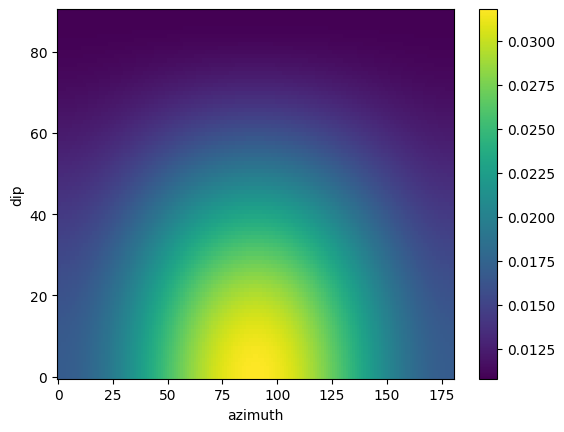

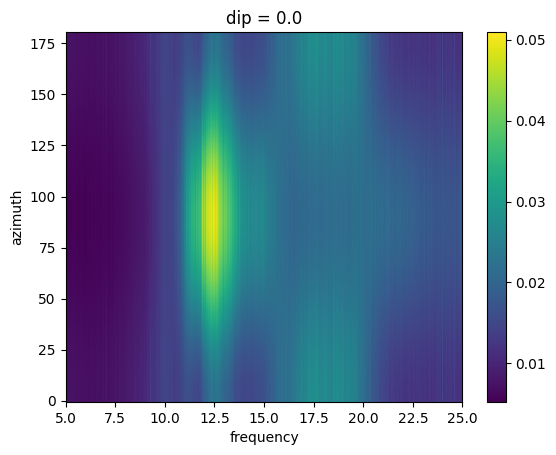

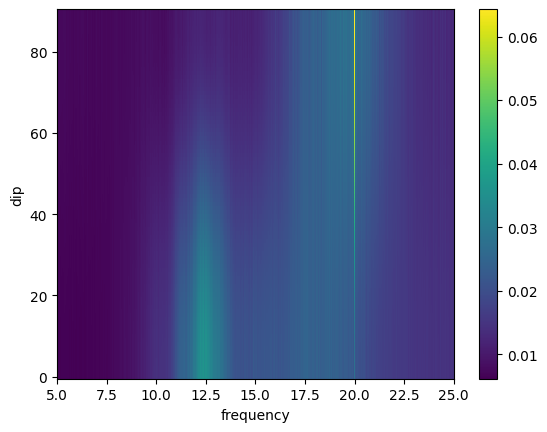

In [ ]:
# tu peux facilement faire des plots simples pour une "tranche" de fréquence 
orientation.sel(frequency=slice(10, 15)).mean('frequency').plot()
plt.show()

# tu peux également faire un plot simple pour une "tranche" de dip
orientation.sel(dip=0, frequency=slice(5, 25)).plot()
plt.show()

# avec l'azimuth moyen? Effectivement ici il faut définir un plan si on n'a pas calculé l'horizontal, c'est à réfléchir 
orientation.sel(frequency=slice(5, 25)).mean('azimuth').plot()
plt.show()

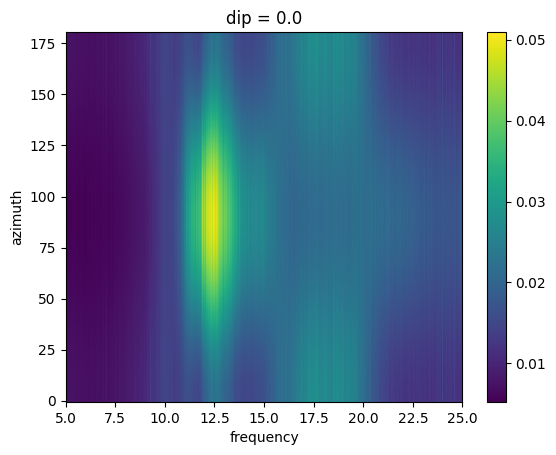